In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import librosa
from librosa import display
import IPython.display as ipd
audio_dir='/content/drive/MyDrive/Colab Notebooks/Audio/'

#Creating Dataset

In [3]:
def get_filename(dir_name):
  filenames_list=[]
  for entry in os.scandir(dir_name):
     if (entry.path.endswith(".wav") and entry.is_file()):
      filenames_list.append(entry.name)
  return filenames_list

def get_subfolders(dir_name):
  dirlist=[]
  for item in os.listdir(dir_name):
    if os.path.isdir(item):
        dirlist.append(item)
  return dirlist

def Audio_to_tensor(dir_name):
  os.chdir(dir_name)
  print(dir_name)
  X=[]
  folder_list=get_subfolders(dir_name)
  avance=1
  for folder in folder_list:
    print("Treating folder",avance,"out of",np.size(folder_list))
    avance=avance+1
    filename_list=get_filename(dir_name+'/'+folder)
    os.chdir(dir_name+'/'+folder)
    for file in filename_list:
      S,sr=librosa.load(dir_name+'/'+folder+'/'+file)
      sf=librosa.feature.mfcc(S,n_mfcc=128,sr=44100)
      X.append(sf)
  X=np.array(X)
  tensor=tf.convert_to_tensor(X,dtype=tf.float32)
  print("Done !")
  return tensor

In [ ]:
X=Audio_to_tensor(audio_dir+'X_train')
y=Audio_to_tensor(audio_dir+'y_train')
X_valid=Audio_to_tensor(audio_dir+'X_valid')
y_valid=Audio_to_tensor(audio_dir+'y_valid')

In [6]:
input_shape = X.shape[1:]

print("Input shape: {}".format(input_shape))

Input shape: (128, 9)


#CNN

## Configuration of our CNN

In [7]:
from tensorflow.keras import callbacks
early_stopping=callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)

In [28]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
        layers.BatchNormalization(input_shape=input_shape),          
        layers.Conv1D(9, 3,padding="same",activation='relu',input_shape=input_shape),
        layers.Dense(units=9)
        #tf.keras.layers.MaxPooling1D(pool_size=2, padding='valid'),
        ])
#adaptive_lr=
tf.keras.optimizers.Adam(learning_rate=tf.keras.optimizers.schedules.LearningRateSchedule)
model.compile(
    optimizer = 'Adam',
    loss = 'mae',)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 128, 9)            36        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 128, 9)            252       
_________________________________________________________________
dense_1 (Dense)              (None, 128, 9)            90        
Total params: 378
Trainable params: 360
Non-trainable params: 18
_________________________________________________________________


## Training of our model

Epoch 1/1500
5/5 [==============================] - 1s 49ms/step - loss: 11.5031 - val_loss: 12.2454
Epoch 2/1500
5/5 [==============================] - 0s 16ms/step - loss: 11.4763 - val_loss: 12.1961
Epoch 3/1500
5/5 [==============================] - 0s 15ms/step - loss: 11.4741 - val_loss: 12.1704
Epoch 4/1500
5/5 [==============================] - 0s 15ms/step - loss: 11.4266 - val_loss: 12.1522
Epoch 5/1500
5/5 [==============================] - 0s 15ms/step - loss: 11.4647 - val_loss: 12.1373
Epoch 6/1500
5/5 [==============================] - 0s 14ms/step - loss: 11.4511 - val_loss: 12.1240
Epoch 7/1500
5/5 [==============================] - 0s 14ms/step - loss: 11.4598 - val_loss: 12.1115
Epoch 8/1500
5/5 [==============================] - 0s 15ms/step - loss: 11.4519 - val_loss: 12.0992
Epoch 9/1500
5/5 [==============================] - 0s 15ms/step - loss: 11.4590 - val_loss: 12.0866
Epoch 10/1500
5/5 [==============================] - 0s 13ms/step - loss: 11.4240 - val_los

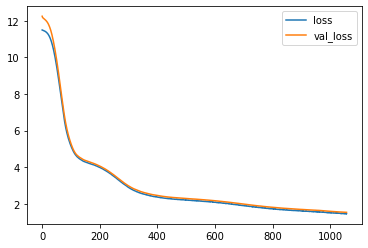

In [29]:
history = model.fit(
    X, y,
    validation_data=(X_valid,y_valid),
    batch_size=256,
    epochs=1500,
    callbacks=[early_stopping]
)
# Start the plot at epoch 10
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

##Results

We tried to make a prediction using our validation data. This works very well but it could be related to the fact that our validation data is very close to our training data.

In [66]:
y_predict=model.predict(X_valid)

### Visualizing our predictions

[Text(0.5, 1.0, 'MFCC')]

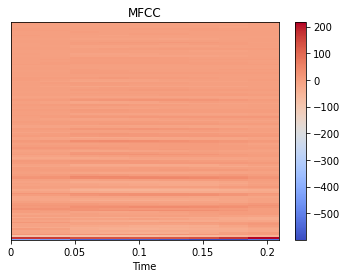

In [67]:
fig, ax = plt.subplots()
img = librosa.display.specshow(y_predict[180], x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')


[Text(0.5, 1.0, 'MFCC')]

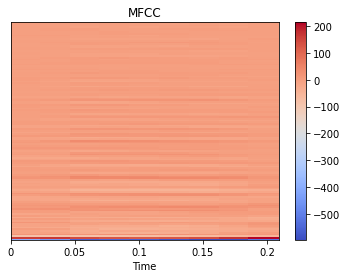

In [68]:
fig, ax = plt.subplots()
img = librosa.display.specshow(y_valid.numpy()[180], x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')


### Listening to the predicitions :


In [69]:
predicted_audio=[]
for i in range (181,200):
  predicted_audio=np.append(predicted_audio,librosa.feature.inverse.mfcc_to_audio(y_predict[i], sr=44100,n_mels=128, dct_type=2, norm='ortho', ref=1.0, lifter=0))
target_audio=[]
for i in range (181,200):
  target_audio=np.append(target_audio,librosa.feature.inverse.mfcc_to_audio(y_valid.numpy()[i], sr=44100,n_mels=128, dct_type=2, norm='ortho', ref=1.0, lifter=0))



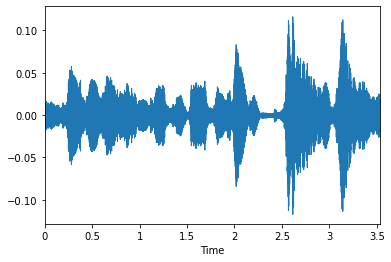

In [58]:
#predicted_audio=librosa.util.normalize(predicted_audio)
librosa.display.waveplot(predicted_audio)

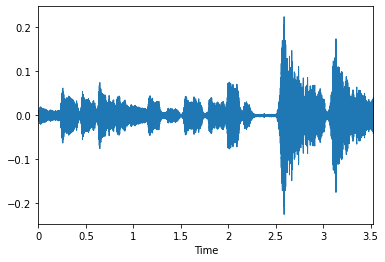

In [62]:
librosa.display.waveplot(target_audio)

In [70]:
ipd.Audio(target_audio,rate=22050)

In [71]:
ipd.Audio(predicted_audio,rate=22050,)

Despite the fact that MFCC degrade our audio signal a lot, we can hear and see thta our predictions are very close to our targets. 
We will try other approachs with our CNN, mainly using STFT and maybe the raw audio to make cleaner predictions